In [1]:
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.profiler import profile, record_function, ProfilerActivity 
from torchmetrics.classification import MulticlassConfusionMatrix
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score

from dataset import CelebASpoofDataset


In [2]:
import sys
import os
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
if project_root not in sys.path:
    sys.path.append(project_root)
print(f"Adding {project_root} to sys.path")

Adding d:\JoshFile\Github\spoofing-recognition\notebooks\training to sys.path


In [3]:
import config

## randomizer

In [4]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


## Utils Functions


In [5]:
import copy
import gc 
import time
def train_model(model, device, train_loader, val_loader, criterion, optimizer, epochs, early_stopping_limit=3,train_transforms=None, val_transforms=None):
    accuracy = Accuracy(task="binary").to(device)
    precision = Precision(task="binary").to(device)
    recall = Recall(task="binary").to(device)
    f1 = F1Score(task="binary").to(device)
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_precision': [],
        'val_accuracy': [],
        'val_recall': [],
        'val_f1': []
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    best_val_precision = 0.0
    early_stopping_counter = 0
    
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
                 record_shapes=True,
                 schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
                 on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/efficientnet'),
                 with_stack=True) as prof:
        for epoch in range(epochs):

            model.train()
            train_loss = 0.0
            time_started = time.time()
            
            
            for images, labels in train_loader:
                with record_function("data_transfer"):
                    images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                with record_function("gpu_transforms"):
                    images = train_transforms(images)
        
                optimizer.zero_grad()
                with record_function("forward_pass"):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * images.size(0)
                prof.step()

            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            true_positives = 0
            false_positives = 0
            
            with torch.no_grad():
                for images, labels in val_loader:
                    with record_function("data_transfer_val"):
                        images, labels = images.to(device), labels.to(device)
                    with record_function("gpu_transforms_val"):
                        images = val_transforms(images)
                    
                    with record_function("forward_pass_val"):
                        outputs = model(images)
                        loss = criterion(outputs, labels)

                    with record_function("loss_accumulation"):
                        val_loss += loss.item() * images.size(0)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                    with record_function("precision_calculation"):
                        precision.update(predicted, labels)
                        accuracy.update(predicted, labels)
                        recall.update(predicted, labels)
                        f1.update(predicted, labels)
                        true_positives  += ((predicted == 1) & (labels == 1)).sum().item()
                        false_positives += ((predicted == 1) & (labels == 0)).sum().item()



            acc_val = accuracy.compute().item()
            prec_val = precision.compute().item()
            rec_val = recall.compute().item()
            f1_val = f1.compute().item()

            avg_train_loss = train_loss / len(train_loader.dataset)
            avg_val_loss = val_loss / len(val_loader.dataset)

            time_ended = time.time()
            epoch_duration = time_ended - time_started
            mins = int(epoch_duration // 60)
            secs = int(epoch_duration % 60)
            
            print(f"Epoch [{epoch+1}/{epochs}] | Time: {mins}m {secs}s Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Precision: {prec_val:.2f}% | Val Accuracy: {acc_val:.2f}% | Val Recall: {rec_val:.2f}% | Val F1: {f1_val:.2f}%")

            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)
            history['val_precision'].append(prec_val)
            history['val_accuracy'].append(acc_val)
            history['val_recall'].append(rec_val)
            history['val_f1'].append(f1_val)

            accuracy.reset()
            precision.reset()
            recall.reset()
            f1.reset()
    
            if best_val_loss > avg_val_loss:
                best_val_loss = avg_val_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                early_stopping_counter = 0 
                print("  -> New best model saved!")
            else:
                early_stopping_counter += 1 
                print(f"  -> No improvement. Counter: {early_stopping_counter}/{early_stopping_limit}")


            # gc.collect()
            # if device.type == 'cuda':
            #     torch.cuda.empty_cache()
                
            if early_stopping_counter >= early_stopping_limit:
                print("Early stopping triggered.")
                break
            


    model.load_state_dict(best_model_wts)
    return model, history

## Params

In [ ]:

# # Add Augmentation for Training
# train_transform = transforms.Compose([
#     transforms.Resize((TARGET_SIZE, TARGET_SIZE)),
#     # transforms.RandomHorizontalFlip(p=0.5),
#     # transforms.RandomRotation(degrees=15),
#     # change to black and white
#     transforms.Grayscale(num_output_channels=3),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=mean, std=std)
# ])

# # Keep Validation/Test pure (Resize only)
# val_transform = transforms.Compose([
#     transforms.Resize((TARGET_SIZE, TARGET_SIZE)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=mean, std=std)
# ])

## Model


In [7]:
from torchvision import models
import torch.nn as nn
# from ultralytics import YOLO
# todo create new file for yolo model
# model = YOLO("yolov8n-cls.pt")
# Load EfficientNet (Pre-trained on 1 million images)
model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT)

# freeze layer
for param in model.features.parameters():
    param.requires_grad = False

# Adjust the final layer for 2 classes (Live/Spoof)
# EfficientNet uses .classifier instead of .fc
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 2)
# model.head.Linear = nn.Linear( in_features, 2)
model



Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to C:\Users\Josh/.cache\torch\hub\checkpoints\efficientnet_v2_m-dc08266a.pth


100%|██████████| 208M/208M [00:05<00:00, 39.7MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

## Dataset


## preparation


In [ ]:
import multiprocessing
from torch.utils.data import Subset
BATCH_SIZE =32
EPOCHS =100
EARLY_STOPPING_LIMIT = 30
BBOX_ORGINAL_SIZE = 224
TARGET_SIZE = 500
# TARGET_SIZE = 224

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
bbox_lookup = "../bbox_lookup.json"

num_cpus = multiprocessing.cpu_count()
workers = 4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

all_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=config.TRAIN_JSON,
    bbox_json_path=bbox_lookup,
    target_size = TARGET_SIZE,
    bbox_original_size = BBOX_ORGINAL_SIZE
)

test_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=config.TEST_JSON,
    bbox_json_path=bbox_lookup,
    target_size = TARGET_SIZE,
    bbox_original_size = BBOX_ORGINAL_SIZE
)

train_ds = Subset(all_ds, range(0, int(0.5 * len(all_ds))))
val_ds = Subset(all_ds, range(int(0.5 * len(all_ds)), len(all_ds)))
device

Loading BBox Cache into RAM...
Loading BBox Cache into RAM...


device(type='cuda')

In [9]:
from torchvision.transforms import v2
gpu_transforms_train = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=15),
]).to(device)

gpu_transforms_val = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
]).to(device)




In [10]:
len(train_ds)

247202

In [11]:
import numpy as np
from torch.utils.data import Subset

def create_subset(dataset, total_size=1000, spoof_percent=0.5):
    """
    Creates a Subset (50% Live / 50% Spoof) by looking at 
    the internal label dictionary instead of loading images.
    """
    num_spoof = int(total_size * spoof_percent)
    num_live = total_size - num_spoof
    live_indices = []
    spoof_indices = []

    print(" Scanning internal label dict for class balance...")
    
    # Fast Loop: Access RAM only, no File I/O
    for idx, key in enumerate(dataset.image_keys):
        # Your specific schema: label is at index 43
        # 0 = Live, 1 = Spoof
        label = dataset.label_dict[key][43]
        
        if label == 0:
            live_indices.append(idx)
        else:
            spoof_indices.append(idx)
            
    print(f" Found: {len(live_indices)} Live | {len(spoof_indices)} Spoof")
    
    # Check if we have enough data
    if len(live_indices) < num_live or len(spoof_indices) < num_spoof:
        raise ValueError(f"Not enough data to create a balanced set of {total_size}. Reduce total_size.")

    # Random Sampling
    selected_live = np.random.choice(live_indices, num_live, replace=False)
    selected_spoof = np.random.choice(spoof_indices, num_spoof, replace=False)
    
    # Combine and Shuffle
    # We shuffle indices so the DataLoader doesn't get [500 Live] then [500 Spoof]
    final_indices = np.concatenate([selected_live, selected_spoof])
    np.random.shuffle(final_indices)
    
    return Subset(dataset, final_indices)


np.random.seed(seed)
spoof_percent = 0.7
small_train_ds = create_subset(train_ds.dataset, total_size=3000, spoof_percent=spoof_percent)
small_val_ds = create_subset(val_ds.dataset, total_size=1000, spoof_percent=spoof_percent)

print(f"Created Balanced Train: {len(small_train_ds)} images")

 Scanning internal label dict for class balance...
 Found: 162462 Live | 331943 Spoof
 Scanning internal label dict for class balance...
 Found: 162462 Live | 331943 Spoof
Created Balanced Train: 3000 images


In [12]:
# use only 1000 images for training next 200 for validation

# small_ds = torch.utils.data.Subset(train_ds, list(range(12000)))
# small_train_ds = torch.utils.data.Subset(small_ds, list(range(0, 10000, 10)))
# small_val_ds = torch.utils.data.Subset(small_ds, list(range(10000, 12000, 10)))
len(small_train_ds)

3000

In [13]:
len(small_val_ds)

1000

In [14]:
small_test_ds = create_subset(test_ds, total_size=400)



 Scanning internal label dict for class balance...
 Found: 19923 Live | 47247 Spoof


In [15]:
# check distribution of live and spoof in small_test_ds

def checkDatasetDistribution(dataset):
    live_count = 0
    spoof_count = 0
    for img, label in dataset:
        if label.item() == 0:
            live_count += 1
        else:
            spoof_count += 1
    print(f"Live count: {live_count}, Spoof count: {spoof_count}")
checkDatasetDistribution(small_test_ds)

Live count: 200, Spoof count: 200


In [16]:
checkDatasetDistribution(small_train_ds)

Live count: 900, Spoof count: 2100


In [17]:
checkDatasetDistribution(small_val_ds)

Live count: 300, Spoof count: 700


## Data Loader

In [18]:
from torch.utils.data import DataLoader
small_train_loader = DataLoader(small_train_ds, 
                                batch_size=BATCH_SIZE, 
                                shuffle=True,
                                num_workers=workers,
                                pin_memory=True,
                                persistent_workers=True
          
                   
)
small_val_loader = DataLoader(small_val_ds, 
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=workers,
                              pin_memory=True,
                              persistent_workers=True
                
                    
)
small_test_loader = DataLoader(small_test_ds, 
                               batch_size=BATCH_SIZE, 
                               shuffle=False,
                                num_workers=workers,
                                pin_memory=True,
                                persistent_workers=True
                                )

In [19]:
sample_img, sample_label = small_train_ds[0]
sample_img.shape, sample_label

(torch.Size([3, 500, 500]), tensor(1))

In [20]:
def checkImage(small_train_ds):
    sample_img, sample_label = small_train_ds
    display_img = sample_img.permute(1, 2, 0)
    display_img = (display_img - display_img.min()) / (display_img.max() - display_img.min())
    plt.imshow(display_img)
    plt.title(f"Label: {'Live' if sample_label == 0 else 'Spoof'}")
    plt.axis('off')
    plt.show()




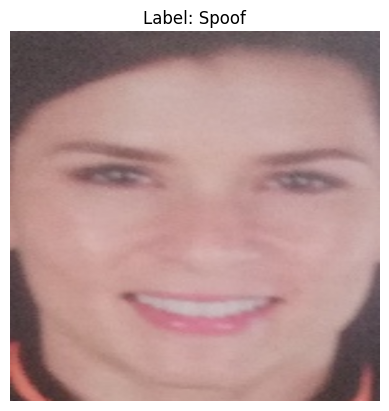

In [21]:
def checkImage(dataset, idx):
    sample_img, sample_label = dataset[idx]
    display_img = sample_img.permute(1, 2, 0).numpy() / 255.0
    plt.imshow(display_img)
    plt.title(f"Label: {'Live' if sample_label == 0 else 'Spoof'}")
    plt.axis('off')
    plt.show()


# 1 = spoof  0 = live 
checkImage(small_train_ds, 210)

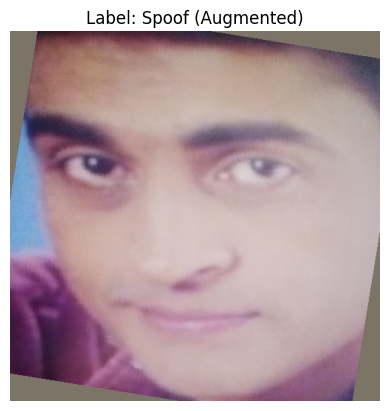

In [22]:
def checkAugmentedImage(dataset, idx, gpu_transforms):
    sample_img, sample_label = dataset[idx]
    
    # Apply GPU transforms (same as training)
    sample_img = sample_img.unsqueeze(0).to(device)  # Add batch dim
    augmented = gpu_transforms(sample_img).squeeze(0).cpu()  # Remove batch dim
    
    # Denormalize from ImageNet stats
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    display_img = augmented * std + mean
    display_img = torch.clamp(display_img, 0, 1)
    
    display_img = display_img.permute(1, 2, 0).numpy()
    
    plt.imshow(display_img)
    plt.title(f"Label: {'Live' if sample_label == 0 else 'Spoof'} (Augmented)")
    plt.axis('off')
    plt.show()

checkAugmentedImage(small_train_ds, 2, gpu_transforms=gpu_transforms_train)

## Train

In [ ]:


model, history = train_model(model=model, 
                             device=device, 
                             train_loader=small_train_loader, 
                             val_loader=small_val_loader,      
                             criterion=criterion, 
                             optimizer=optimizer, 
                             epochs=EPOCHS, 
                             early_stopping_limit=EARLY_STOPPING_LIMIT,
                             train_transforms=gpu_transforms_train,
                             val_transforms=gpu_transforms_val
                             )

Epoch [1/100] | Time: 1m 36s Train Loss: 0.5572 | Val Loss: 0.5167 | Val Precision: 0.85% | Val Accuracy: 0.84% | Val Recall: 0.94% | Val F1: 0.89%
  -> New best model saved!
Epoch [2/100] | Time: 0m 56s Train Loss: 0.4460 | Val Loss: 0.4281 | Val Precision: 0.93% | Val Accuracy: 0.90% | Val Recall: 0.93% | Val F1: 0.93%
  -> New best model saved!
Epoch [3/100] | Time: 0m 56s Train Loss: 0.3823 | Val Loss: 0.3922 | Val Precision: 0.97% | Val Accuracy: 0.90% | Val Recall: 0.89% | Val F1: 0.93%
  -> New best model saved!
Epoch [4/100] | Time: 0m 56s Train Loss: 0.3356 | Val Loss: 0.3624 | Val Precision: 0.97% | Val Accuracy: 0.90% | Val Recall: 0.89% | Val F1: 0.93%
  -> New best model saved!
Epoch [5/100] | Time: 0m 57s Train Loss: 0.3034 | Val Loss: 0.3543 | Val Precision: 0.97% | Val Accuracy: 0.89% | Val Recall: 0.87% | Val F1: 0.92%
  -> New best model saved!
Epoch [6/100] | Time: 0m 58s Train Loss: 0.2813 | Val Loss: 0.2807 | Val Precision: 0.97% | Val Accuracy: 0.92% | Val Recall:

C:\Users\Josh\AppData\Local\Temp\ipykernel_25076\163929919.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_loss.show()
C:\Users\Josh\AppData\Local\Temp\ipykernel_25076\163929919.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_precision.show()


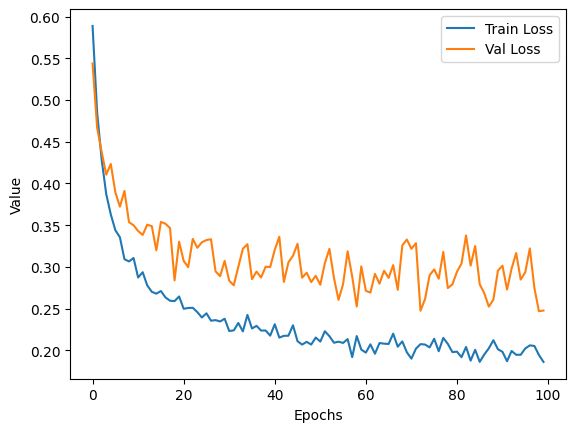

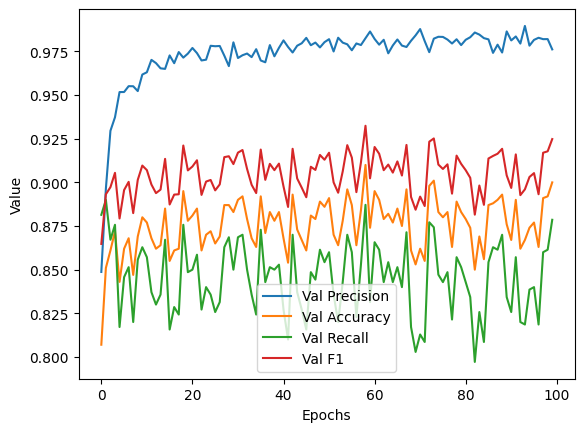

In [ ]:
def display_train_result(history):
    fig_loss, ax1 = plt.subplots()
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Value')
    ax1.legend()
    fig_loss.show()

    fig_precision, ax2 = plt.subplots() 
    ax2.plot(history['val_precision'], label='Val Precision')
    ax2.plot(history['val_accuracy'], label='Val Accuracy')
    ax2.plot(history['val_recall'], label='Val Recall')
    ax2.plot(history['val_f1'], label='Val F1')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Value')
    ax2.legend()
    fig_precision.show()

    return fig_loss, fig_precision



train_loss_fig, precision_fig = display_train_result(history)

## test


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live           192     |          8
Spoof           49     |        151


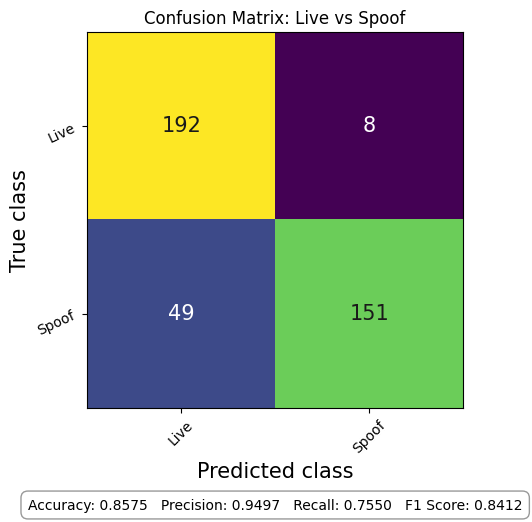

Accuracy: 0.8575
Precision: 0.9497
Recall:    0.7550
F1 Score:  0.8412


In [ ]:

def evaluate(model, dataloader, device, val_transforms=None):
    confmat = MulticlassConfusionMatrix(num_classes=2).to(device)
    accuracy = Accuracy(task="binary").to(device)
    precision = Precision(task="binary").to(device)
    recall = Recall(task="binary").to(device)
    f1 = F1Score(task="binary").to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            images = val_transforms(images)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            # Update the metrics with this batch
            confmat.update(preds, labels)
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1.update(preds, labels)

    # Compute the final results
    final_matrix = confmat.compute()
    print("\nConfusion Matrix:")
    print(f"         Predicted Live | Predicted Spoof")
    print(f"Live        {final_matrix[0,0]:>6}     |     {final_matrix[0,1]:>6}")
    print(f"Spoof       {final_matrix[1,0]:>6}     |     {final_matrix[1,1]:>6}")
    acc_val = accuracy.compute()
    prec_val = precision.compute()
    rec_val = recall.compute()
    f1_val = f1.compute()

    # Plot the matrix
    fig, ax = confmat.plot(labels=["Live", "Spoof"])
    ax.set_title("Confusion Matrix: Live vs Spoof")
    
    # Add metrics as text below the matrix
    metrics_text = (f"Accuracy: {acc_val:.4f}   "
                    f"Precision: {prec_val:.4f}   "
                    f"Recall: {rec_val:.4f}   "
                    f"F1 Score: {f1_val:.4f}")
    
    # Position the text at the bottom center of the figure
    fig.text(0.5, -0.05, metrics_text, ha='center', fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))
    
    plt.show()

    print(f"Accuracy: {acc_val:.4f}")
    print(f"Precision: {prec_val:.4f}")
    print(f"Recall:    {rec_val:.4f}")
    print(f"F1 Score:  {f1_val:.4f}")

    return fig, acc_val, prec_val, rec_val, f1_val

confusion_matrix, accuracy, precision, recall, f1 = evaluate(model=model, dataloader=small_test_loader, device=device, val_transforms=gpu_transforms_val)

In [ ]:
from pathlib import Path
def create_save_new_path(save_path, path_name, num):
    new_dir = save_path / f"{path_name}_{num}"
    if new_dir.exists():
        return create_save_new_path(save_path, path_name, num + 1)
    else:
        new_dir.mkdir(parents=True)
        return new_dir



def save_results(model, confusion_matrix_fig, train_loss_fig, precision_fig):
    
    save_path = Path("train_results")
    path_name = "train"
    num = 0
    
    save_path.mkdir(parents=True, exist_ok=True)
    
    # create new dir if already exist
    new_path = create_save_new_path(save_path, path_name, num)

    print(f"Saving results to: {new_path}")

    confusion_matrix_fig.savefig(new_path / "confusion_matrix.png", bbox_inches='tight')
    train_loss_fig.savefig(new_path / "train_loss.png")
    precision_fig.savefig(new_path / "precision.png")

    torch.save(model.state_dict(), new_path / "model.pt")
save_results(model=model, confusion_matrix_fig=confusion_matrix, train_loss_fig=train_loss_fig, precision_fig=precision_fig)

Saving results to: train_results\train_9


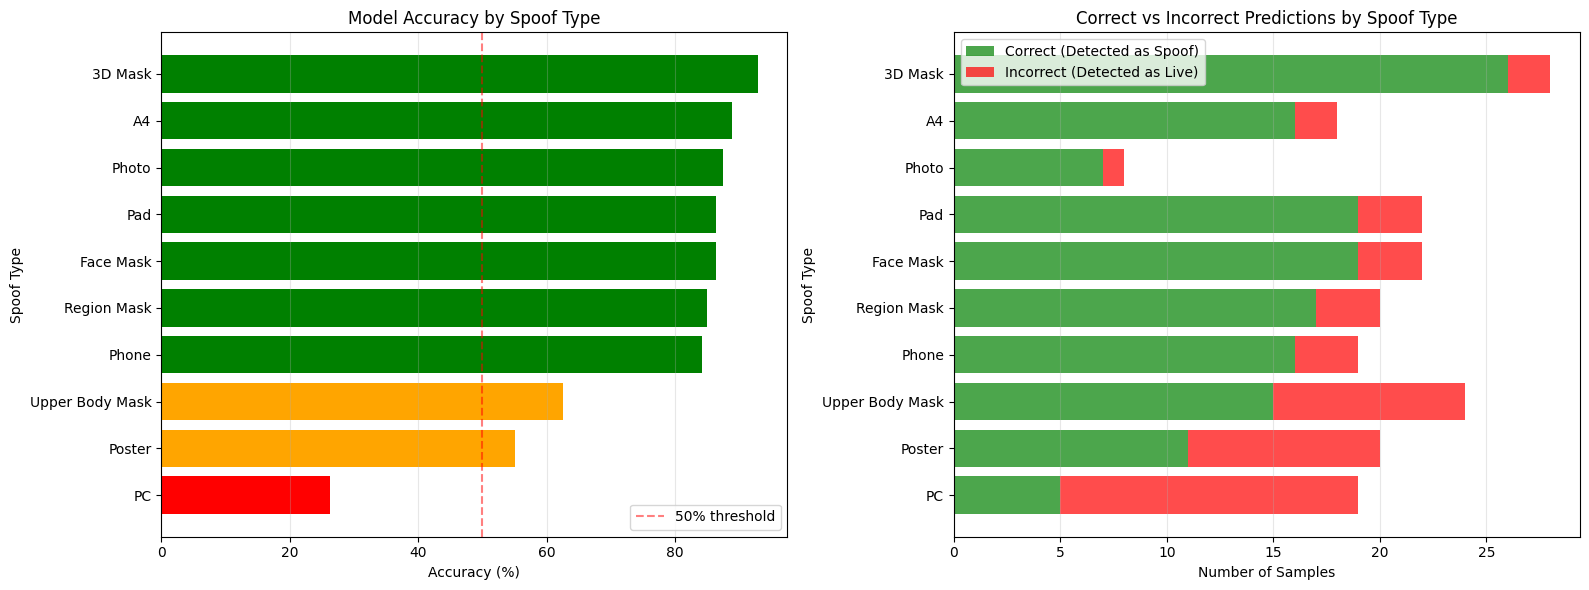


Spoof Type Analysis Results:
     Spoof Type  Type ID  Total  Correct  Incorrect  Accuracy (%)
             PC        7     19        5         14     26.315789
         Poster        2     20       11          9     55.000000
Upper Body Mask        5     24       15          9     62.500000
          Phone        9     19       16          3     84.210526
    Region Mask        6     20       17          3     85.000000
      Face Mask        4     22       19          3     86.363636
            Pad        8     22       19          3     86.363636
          Photo        1      8        7          1     87.500000
             A4        3     18       16          2     88.888889
        3D Mask       10     28       26          2     92.857143


Worst Performing Spoof Types (Accuracy < 70%):
     Spoof Type  Type ID  Total  Correct  Incorrect  Accuracy (%)
             PC        7     19        5         14     26.315789
         Poster        2     20       11          9     55.0000

In [ ]:
def analyze_spoof_types(model, dataset, device, val_transforms):
    """
    Analyzes model performance across different spoof types.
    Spoof type is at index 40 in the label array.
    """
    spoof_type_labels = {
        0: 'Live',
        1: 'Photo',
        2: 'Poster',
        3: 'A4',
        4: 'Face Mask',
        5: 'Upper Body Mask',
        6: 'Region Mask',
        8: 'Pad',
        7: "PC",
        9: 'Phone',
        10: '3D Mask'
    }
    
    model.eval()
    
    # Dictionary to store results per spoof type
    spoof_type_results = {}
    
    with torch.no_grad():
        for idx in range(len(dataset)):
            img, label = dataset[idx]
            
            # Get the original key to access full label info
            if hasattr(dataset, 'dataset'):  # If it's a Subset
                actual_idx = dataset.indices[idx]
                image_key = dataset.dataset.image_keys[actual_idx]
                full_labels = dataset.dataset.label_dict[image_key]
            else:
                image_key = dataset.image_keys[idx]
                full_labels = dataset.label_dict[image_key]
            
            spoof_type = full_labels[40]  # Spoof type at index 40
            live_spoof_label = full_labels[43]  # Live/Spoof at index 43
            
            # Only analyze spoof images (label = 1)
            if live_spoof_label != 1:
                continue
            
            # Prepare image for model
            img = img.unsqueeze(0).to(device)
            img = val_transforms(img)
            
            # Get prediction
            output = model(img)
            pred = torch.argmax(output, dim=1).item()
            
            # Initialize spoof type entry if needed
            if spoof_type not in spoof_type_results:
                spoof_type_results[spoof_type] = {
                    'total': 0,
                    'correct': 0,
                    'incorrect': 0
                }
            
            # Update statistics
            spoof_type_results[spoof_type]['total'] += 1
            if pred == 1:  # Correctly identified as spoof
                spoof_type_results[spoof_type]['correct'] += 1
            else:  # Incorrectly identified as live
                spoof_type_results[spoof_type]['incorrect'] += 1
    
    # Calculate accuracy per spoof type
    results_df = []
    for spoof_type, stats in sorted(spoof_type_results.items()):
        accuracy = (stats['correct'] / stats['total'] * 100) if stats['total'] > 0 else 0
        results_df.append({
            'Spoof Type': spoof_type_labels.get(spoof_type, 'Unknown'),
            'Type ID': spoof_type,
            'Total': stats['total'],
            'Correct': stats['correct'],
            'Incorrect': stats['incorrect'],
            'Accuracy (%)': accuracy
        })
    
    results_df = pd.DataFrame(results_df)
    results_df = results_df.sort_values('Accuracy (%)')
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar chart of accuracy per spoof type
    ax1.barh(results_df['Spoof Type'].astype(str), results_df['Accuracy (%)'], 
             color=['red' if x < 50 else 'orange' if x < 80 else 'green' 
                    for x in results_df['Accuracy (%)']])
    ax1.set_xlabel('Accuracy (%)')
    ax1.set_ylabel('Spoof Type')
    ax1.set_title('Model Accuracy by Spoof Type')
    ax1.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
    ax1.legend()
    ax1.grid(axis='x', alpha=0.3)
    
    # Stacked bar chart showing correct vs incorrect
    ax2.barh(results_df['Spoof Type'].astype(str), results_df['Correct'], 
             label='Correct (Detected as Spoof)', color='green', alpha=0.7)
    ax2.barh(results_df['Spoof Type'].astype(str), results_df['Incorrect'], 
             left=results_df['Correct'], label='Incorrect (Detected as Live)', 
             color='red', alpha=0.7)
    ax2.set_xlabel('Number of Samples')
    ax2.set_ylabel('Spoof Type')
    ax2.set_title('Correct vs Incorrect Predictions by Spoof Type')
    ax2.legend()
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nSpoof Type Analysis Results:")
    print("=" * 80)
    print(results_df.to_string(index=False))
    print("\n" + "=" * 80)
    print(f"\nWorst Performing Spoof Types (Accuracy < 70%):")
    worst = results_df[results_df['Accuracy (%)'] < 70]
    if len(worst) > 0:
        print(worst.to_string(index=False))
    else:
        print("None - All spoof types have >70% accuracy!")
    
    return results_df, fig

# Run the analysis
spoof_analysis_df, spoof_fig = analyze_spoof_types(
    model=model,
    dataset=small_test_ds,
    device=device,
    val_transforms=gpu_transforms_val
)

In [ ]:
# Check a few samples
for i in range(5):
    _, label = small_test_ds[i]
    print(f"Sample {i}: Label = {label.item()} ({'Live' if label.item() == 0 else 'Spoof'})")

Sample 0: Label = 1 (Spoof)
Sample 1: Label = 1 (Spoof)
Sample 2: Label = 0 (Live)
Sample 3: Label = 1 (Spoof)
Sample 4: Label = 0 (Live)


In [ ]:
# Test with a known Live sample
img, label = small_test_ds[2]  # Adjust index to find a Live sample
print(f"True label: {'Live' if label == 0 else 'Spoof'}")

img = img.unsqueeze(0).to(device)
img = gpu_transforms_val(img)
output = model(img)
pred = torch.argmax(output, dim=1).item()
print(f"Predicted: {'Live' if pred == 0 else 'Spoof'}")

True label: Live
Predicted: Live
